Operate this notebook with the sunpyenv.
This is the analysis of jet on 24 July 2021 associated with a type II.
In here I want to calculate the speed of the jet using a time-distance plot, but I will also use this to benchmark ideas on how to do this in citizen science in the future

# Overview of the event

In [1]:
import os

import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.visualization import ImageNormalize, SqrtStretch

import sunpy.coordinates  # NOQA
import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as a

C:\Users\sophie.musset\Anaconda3\envs\sunpyenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download full-Sun data to choose the FOV

In [2]:
time_range = a.Time("2021-07-24T15:18:00", "2021-07-24T15:19:00")
Fido.search(
    time_range,
    a.Instrument.aia,
    a.Wavelength(304*u.Angstrom),
    a.Sample(50*u.second)
)

Start Time,End Time,Source,Instrument,Wavelength,Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size
,,,,Angstrom,,,,,,,Mibyte
Time,Time,str3,str3,float64[2],str4,str9,str6,str4,str4,str8,float64
2021-07-24 15:18:05.000,2021-07-24 15:18:06.000,SDO,AIA,304.0 .. 304.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2021-07-24 15:18:53.000,2021-07-24 15:18:54.000,SDO,AIA,304.0 .. 304.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844


In [3]:
aia_query = a.Instrument.aia & a.Wavelength(304*u.Angstrom) & a.Sample(50*u.second)

In [4]:
q = Fido.search(time_range, aia_query)

In [7]:
files = Fido.fetch(q)

Files Downloaded:   0%|                                                                        | 0/2 [01:30<?, ?file/s]

2/0 files failed to download. Please check `.errors` for details


In [9]:
files.errors

 https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=304_1406215124-1406215124,
 Timeout on reading data from socket,
 https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=304_1406215172-1406215172,
 Timeout on reading data from socket]

### If that download is not working (as often)

In [2]:
data_dir = "C:\\Users\sophie.musset\\sunpy\\data\\"
file = data_dir+"aia_lev1_304a_2021_07_24t15_18_05_13z_image_lev1.fits"
file

'C:\\Users\\sophie.musset\\sunpy\\data\\aia_lev1_304a_2021_07_24t15_18_05_13z_image_lev1.fits'

### If it worked

In [6]:
file = files[0]

IndexError: list index out of range

### In any case, once the file is known

In [3]:
aia_map = sunpy.map.Map(file)

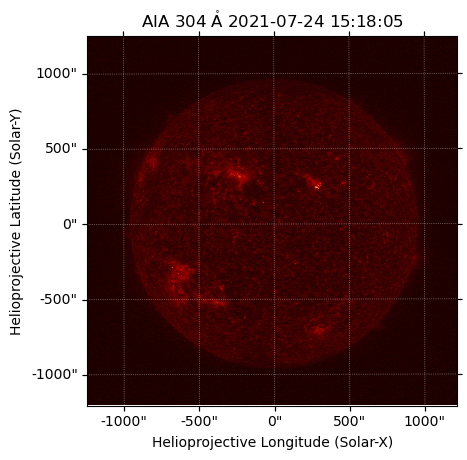

In [4]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(projection=aia_map)
image = aia_map.plot(axes=ax)

plt.show()

Choose the FOV

In [5]:
bottom_left = SkyCoord(200*u.arcsec, 150*u.arcsec, frame=aia_map.coordinate_frame)
top_right = SkyCoord(400*u.arcsec, 400*u.arcsec, frame=aia_map.coordinate_frame)
aia_submap = aia_map.submap(bottom_left, top_right=top_right)

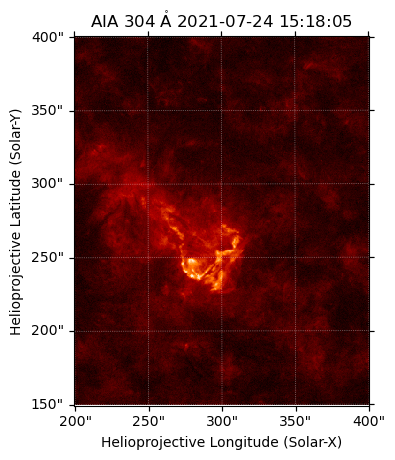

In [6]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(projection=aia_submap)
image = aia_submap.plot(axes=ax)

plt.show()

In [7]:
bottom_left

<SkyCoord (Helioprojective: obstime=2021-07-24T15:18:05.130, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2021-07-24T15:18:05.130, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.01007704, 5.19189356, 1.51937663e+11)>): (Tx, Ty) in arcsec
    (200., 150.)>

## Define time and FOV

In [14]:
#start_time = Time('2021-07-24T15:10:00', scale='utc', format='isot')
start_time = Time('2021-07-24T15:15:00', scale='utc', format='isot')
bottom_left = SkyCoord(200*u.arcsec, 150*u.arcsec, obstime=start_time, observer="earth", frame="helioprojective")
top_right = SkyCoord(400*u.arcsec, 400*u.arcsec, obstime=start_time, observer="earth", frame="helioprojective")
bottom_left

<SkyCoord (Helioprojective: obstime=2021-07-24T15:15:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (Tx, Ty) in arcsec
    (200., 150.)>

## Request cutouts

In [155]:
cutout = a.jsoc.Cutout(bottom_left, top_right=top_right, tracking=False)

In [156]:
jsoc_email = "sophie.musset@esa.int"

In [247]:
type(304*u.angstrom)

astropy.units.quantity.Quantity

In [157]:
query = Fido.search(
    a.Time(start_time, start_time + 1000*u.s), ### to check
    a.Wavelength(304*u.angstrom),
    a.Sample(12*u.s), ### to change
    a.jsoc.Series.aia_lev1_euv_12s,
    a.jsoc.Notify(jsoc_email),
    a.jsoc.Segment.image,
    cutout,
)
print(query)

Results from 1 Provider:

84 Results from the JSOCClient:
Source: http://jsoc.stanford.edu

       T_REC         TELESCOP INSTRUME WAVELNTH CAR_ROT
-------------------- -------- -------- -------- -------
2021-07-24T15:14:59Z  SDO/AIA    AIA_4      304    2246
2021-07-24T15:15:11Z  SDO/AIA    AIA_4      304    2246
2021-07-24T15:15:23Z  SDO/AIA    AIA_4      304    2246
2021-07-24T15:15:35Z  SDO/AIA    AIA_4      304    2246
2021-07-24T15:15:47Z  SDO/AIA    AIA_4      304    2246
2021-07-24T15:15:59Z  SDO/AIA    AIA_4      304    2246
2021-07-24T15:16:11Z  SDO/AIA    AIA_4      304    2246
2021-07-24T15:16:23Z  SDO/AIA    AIA_4      304    2246
2021-07-24T15:16:35Z  SDO/AIA    AIA_4      304    2246
2021-07-24T15:16:47Z  SDO/AIA    AIA_4      304    2246
                 ...      ...      ...      ...     ...
2021-07-24T15:29:35Z  SDO/AIA    AIA_4      304    2246
2021-07-24T15:29:47Z  SDO/AIA    AIA_4      304    2246
2021-07-24T15:29:59Z  SDO/AIA    AIA_4      304    2246
2021-07-24T1

In [158]:
#files = Fido.fetch(query, overwrite=True)
files = Fido.fetch(query, overwrite=False)
files.sort()

Export request pending. [id=JSOC_20231117_1197, status=2]
Waiting for 0 seconds...
84 URLs found for download. Full request totalling 8MB


Files Downloaded: 100%|██████████████████████████████████████████████████████████████| 84/84 [01:15<00:00,  1.11file/s]


## Alternatively, find existing cutouts on my computer

In [8]:
import glob
files = glob.glob(data_dir+"aia.lev1_euv_12s.2021-07-24T15*.304.image.fits")
len(files)

85

## Plot the data selected

In [9]:
aia_map = sunpy.map.Map(files[30])

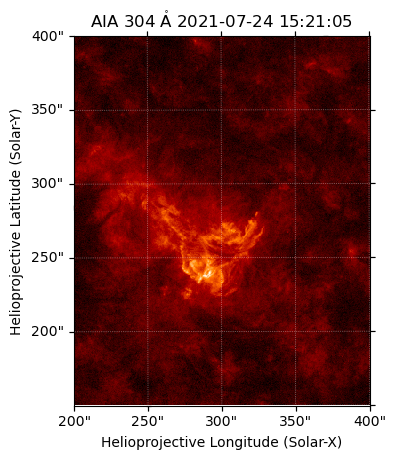

In [10]:
### fig = plt.figure(dpi=300) ### export quality
fig = plt.figure()
ax = fig.add_subplot(projection=aia_map)
image = aia_map.plot(axes=ax)

plt.show()

# Decide on a rectangle

In [11]:
import numpy as np

Add rectangle around the jet   
Definition of x1, x2, dx, dx' in https://www.notion.so/NASA-jet-project-68d37eef66674df9a77c8f846c14f88b?pvs=4#4c9cdd719b4f4700bb051a038beb4004

In [256]:
rectangle_center = [315*u.arcsec,260*u.arcsec]  ## in arcsec
rectangle_width = 20*u.arcsec          ## in arcsec
rectangle_length = 80*u.arcsec        ## in arcsec
rectangle_angle = Angle(45, u.degree)          ## in degrees
x1 = rectangle_center[0] - rectangle_length/2.*np.cos(rectangle_angle.radian) - rectangle_width/2*np.sin(rectangle_angle.radian)
x2 = rectangle_center[0] - rectangle_length/2.*np.cos(rectangle_angle.radian) + rectangle_width/2*np.sin(rectangle_angle.radian)
y1 = rectangle_center[1] - rectangle_length/2.*np.sin(rectangle_angle.radian) + rectangle_width/2*np.cos(rectangle_angle.radian)
y2 = rectangle_center[1] - rectangle_length/2.*np.sin(rectangle_angle.radian) - rectangle_width/2*np.cos(rectangle_angle.radian)
dx = rectangle_length*np.cos(rectangle_angle.radian)
dy = rectangle_length*np.sin(rectangle_angle.radian)
dxp = rectangle_width*np.sin(rectangle_angle.radian)
dyp = rectangle_width*np.cos(rectangle_angle.radian)

Create a coordinate object for the rectangle center

In [15]:
rectangle_center_coord = SkyCoord(rectangle_center[0], rectangle_center[1], 
                                  obstime=start_time, 
                                  observer="earth", 
                                  frame="helioprojective")

Create lines to be drawn to make the rectangle

In [16]:
## we need the lines to be nd.array so we do not take the units of these values. Keep in mind everything is in arcsec
line1x = np.array([x1.value, (x1+dx).value])
line1y = np.array([y1.value, (y1+dy).value])
line2x = np.array([(x1+dxp).value, (x1+dx+dxp).value]) 
line2y = np.array([(y1-dyp).value, (y1+dy-dyp).value])
line3x = np.array([x1.value, (x1+dxp).value])
line3y = np.array([y1.value, (y1-dyp).value])
line4x = np.array([(x1+dx).value, (x1+dx+dxp).value])
line4y = np.array([(y1+dy).value, (y1+dy-dyp).value])

Plot the map and the rectangle center and the rectangle sides

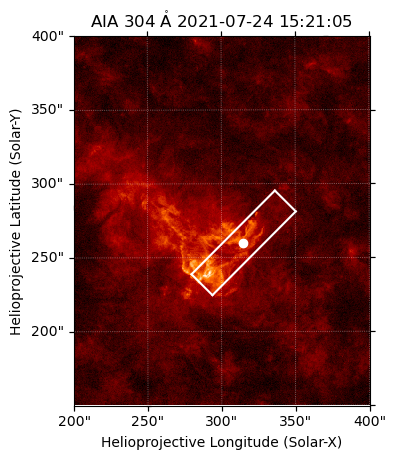

In [17]:
fig = plt.figure()
ax = fig.add_subplot(projection=aia_map)
image = aia_map.plot(axes=ax)

# Note that the coordinates need to be in degrees rather than arcseconds.
ax.plot(line1x*u.arcsec.to(u.deg), line1y*u.arcsec.to(u.deg),
        color='white',
        transform=ax.get_transform("world"))
ax.plot(line2x*u.arcsec.to(u.deg), line2y*u.arcsec.to(u.deg),
        color='white',
        transform=ax.get_transform("world"))
ax.plot(line3x*u.arcsec.to(u.deg), line3y*u.arcsec.to(u.deg),
        color='white',
        transform=ax.get_transform("world"))
ax.plot(line4x*u.arcsec.to(u.deg), line4y*u.arcsec.to(u.deg),
        color='white',
        transform=ax.get_transform("world"))
ax.plot_coord(rectangle_center_coord, marker='o', color='white')
plt.show()

### Extract coordinates of the rectangle in pixels

We will extract the center of the box in pixel coordinates, then calculate the width and length of the box in pixels too. In here we are talking about the AIA pixels. We will keep the angle of the box as defined.

In [249]:
rectangle_center_coord = SkyCoord(rectangle_center[0], rectangle_center[1], 
                                  obstime=aia_map.date,#obstime=start_time, 
                                  observer="earth", 
                                  frame="helioprojective")
px, py = aia_map.wcs.world_to_pixel(rectangle_center_coord)

In [19]:
aia_pixel_scale = 0.5*(aia_map.scale[0]+aia_map.scale[1])

In [20]:
rectangle_width_inpix = rectangle_width/aia_pixel_scale
rectangle_length_inpix = rectangle_length/aia_pixel_scale

# Create time-distance plot

Extract data from the map

In [21]:
data_array = aia_map.data

Define rotation angle: from the rectangle defined before

In [22]:
rotation_angle = rectangle_angle

Plot the data without rotation and the rectangle center

C:\Users\sophie.musset\AppData\Local\Temp\ipykernel_24132\4155190472.py:4: RuntimeWarning: divide by zero encountered in log
  ax1.imshow(np.log(img), cmap='gray', origin="lower")


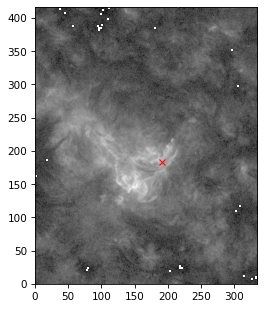

In [23]:
fig = plt.figure(dpi=75)
ax1 = fig.subplots(1, 1)
img = data_array
ax1.imshow(np.log(img), cmap='gray', origin="lower")
ax1.plot(px,py, marker='x',c='red')
plt.show()

## Rotate the map

In [24]:
from scipy import ndimage, datasets

In [25]:
rotated_data = np.log(ndimage.rotate(data_array, rotation_angle, reshape=True))

C:\Users\sophie.musset\AppData\Local\Temp\ipykernel_24132\2813143265.py:1: RuntimeWarning: divide by zero encountered in log
  rotated_data = np.log(ndimage.rotate(data_array, rotation_angle, reshape=True))
C:\Users\sophie.musset\AppData\Local\Temp\ipykernel_24132\2813143265.py:1: RuntimeWarning: invalid value encountered in log
  rotated_data = np.log(ndimage.rotate(data_array, rotation_angle, reshape=True))


Define a function to do the coordinate transformation between the pixel coordinates in the original data array and the pixel coordinates in the rotated data array, with the `reshape=True` when calling `ndimage.rotate()`

In [26]:
def coordinates_in_rotated_frame(px,py,rotation_angle,array):
    # (px,py) are the coordinates (in pixel coordinates) of a pixel in the array
    # rotation_angle should be provided with units
    # array is the data array before rotation
    
    # extract the width and length of the data array
    Lx = np.shape(array)[1]
    Ly = np.shape(array)[0]

    # calculate polar coordinates before rotation
    center_r = np.sqrt(px*px+py*py)
    center_angle = np.arctan(py/px) * u.rad
    
    # polar coordinate in (intermediary) rotated frame 
    new_center_r = center_r
    new_angle = center_angle - rotation_angle 

    # shift in x and y for the final frame
    if (rotation_angle>=0)&(rotation_angle<=90*u.deg):
        x_shift = 0
        y_shift = Lx*np.sin(rotation_angle)
    if (rotation_angle>90*u.deg)&(rotation_angle<=180*u.deg):
        x_shift = Lx*np.abs(np.cos(rotation_angle))
        y_shift = Lx*np.abs(np.sin(rotation_angle)) + Ly*np.abs(np.cos(rotation_angle))
    if (rotation_angle>=-90*u.deg)&(rotation_angle<0*u.deg):
        x_shift = Ly*np.abs(np.sin(rotation_angle))
        y_shift = 0
    if (rotation_angle>-180*u.deg)&(rotation_angle<-90*u.deg):
        x_shift = Lx*np.abs(np.cos(rotation_angle)) + Ly*np.abs(np.sin(rotation_angle))
        y_shift = Ly*np.abs(np.cos(rotation_angle))
    
    #new coordinates
    new_px = new_center_r*np.cos(new_angle) + x_shift
    new_py = new_center_r*np.sin(new_angle) + y_shift

    return np.array([new_px,new_py])

Calculate new coordinates and use it to plot the rotated array

In [27]:
new_coords = coordinates_in_rotated_frame(px,py,rotation_angle,data_array)

In [28]:
rectangle_xx = new_coords[0] + 0.5*rectangle_length_inpix.value*np.array([-1,1])
rectangle_yy = new_coords[1] + 0.5*rectangle_width_inpix.value*np.array([-1,1])
int(rectangle_xx[0])

197

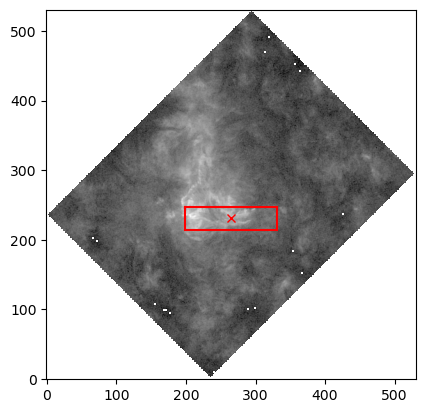

In [29]:
fig = plt.figure(dpi=100)
ax = fig.subplots(1, 1)
ax.imshow(rotated_data, cmap='gray', origin="lower")
ax.plot(new_coords[0],new_coords[1], marker='x',c='red')

ax.plot(rectangle_xx, np.array([rectangle_yy[0],rectangle_yy[0]]),
        color='red')
ax.plot(rectangle_xx, np.array([rectangle_yy[1],rectangle_yy[1]]),
        color='red')
ax.plot(np.array([rectangle_xx[0],rectangle_xx[0]]), rectangle_yy,
        color='red')
ax.plot(np.array([rectangle_xx[1],rectangle_xx[1]]), rectangle_yy,
        color='red')

plt.show()

Select the data in the rectangle and sum everything in the y-direction

In [33]:
in_box = rotated_data[ int(rectangle_yy[0]):int(rectangle_yy[1]), int(rectangle_xx[0]):int(rectangle_xx[1])]

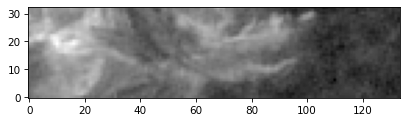

In [34]:
fig = plt.figure(dpi=75)
ax1 = fig.subplots(1, 1)
ax1.imshow(in_box, cmap='gray', origin="lower")
plt.show()

In [36]:
np.shape(in_box)

(33, 134)

In [39]:
a=np.sum(in_box,0)
np.shape(a)

(134,)

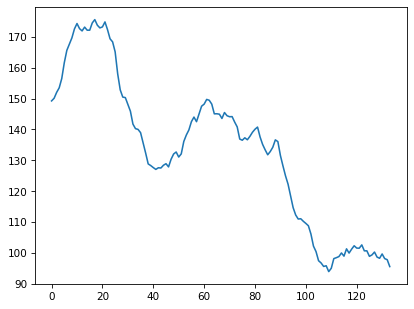

In [41]:
fig = plt.figure(dpi=75)
ax1 = fig.subplots(1, 1)
ax1.plot(a)
plt.show()

### Loop over all the cutouts

Need to create a routine that will take one map, the box parameters, and do:
- extract the data and the box parameters in pixel
- rotate the image
- extract the data in the box and sum over the width

In [118]:
def extract_distance_line_from_box(cutout_map, box_center, box_width, box_length, box_angle):
    
    ### Extract information from the map
    data_array = cutout_map.data
    pixel_scale = 0.5*(cutout_map.scale[0]+cutout_map.scale[1])
    
    ### Calculate box information in pixels
    rectangle_width_inpix = box_width/pixel_scale
    rectangle_length_inpix = box_length/pixel_scale
    rectangle_center_coord = SkyCoord(box_center[0], box_center[1], 
                                  obstime=cutout_map.date, ### the box will "follow" the data in time
                                  observer="earth", 
                                  frame="helioprojective")
    px, py = cutout_map.wcs.world_to_pixel(rectangle_center_coord)
    
    ### rotate data
    rotation_angle = box_angle
    rotated_data = ndimage.rotate(data_array, rotation_angle, reshape=True)
    
    ### calculate coordinates of the box in the rotated data
    new_coords = coordinates_in_rotated_frame(px,py,rotation_angle,data_array)
    rectangle_xx = new_coords[0] + 0.5*rectangle_length_inpix.value*np.array([-1,1])
    rectangle_yy = new_coords[1] + 0.5*rectangle_width_inpix.value*np.array([-1,1])
    
    ### extract data
    in_box = rotated_data[ int(rectangle_yy[0]):int(rectangle_yy[1]), int(rectangle_xx[0]):int(rectangle_xx[1])]
    line = np.sum(in_box,0)
    
    ## create a array for the axis
    distance_axis = np.squeeze(np.arange(len(line))*u.pixel*pixel_scale)
    
    return line, distance_axis

In [120]:
line, distance = extract_distance_line_from_box(aia_map, rectangle_center, rectangle_width, rectangle_length, rectangle_angle)
np.shape(distance)

distance
#pixel_scale = 0.5*(aia_map.scale[0]+aia_map.scale[1])
#type(pixel_scale)

<Quantity [ 0.        ,  0.60016501,  1.20033002,  1.80049503,  2.40066004,
            3.00082505,  3.60099005,  4.20115506,  4.80132007,  5.40148508,
            6.00165009,  6.6018151 ,  7.20198011,  7.80214512,  8.40231013,
            9.00247514,  9.60264014, 10.20280515, 10.80297016, 11.40313517,
           12.00330018, 12.60346519, 13.2036302 , 13.80379521, 14.40396022,
           15.00412523, 15.60429023, 16.20445524, 16.80462025, 17.40478526,
           18.00495027, 18.60511528, 19.20528029, 19.8054453 , 20.40561031,
           21.00577532, 21.60594032, 22.20610533, 22.80627034, 23.40643535,
           24.00660036, 24.60676537, 25.20693038, 25.80709539, 26.4072604 ,
           27.00742541, 27.60759041, 28.20775542, 28.80792043, 29.40808544,
           30.00825045, 30.60841546, 31.20858047, 31.80874548, 32.40891049,
           33.0090755 , 33.6092405 , 34.20940551, 34.80957052, 35.40973553,
           36.00990054, 36.61006555, 37.21023056, 37.81039557, 38.41056058,
           3

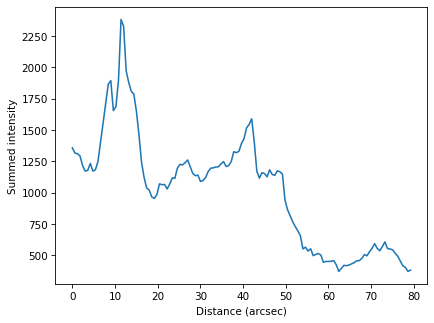

In [124]:
fig = plt.figure(dpi=75)
ax = fig.subplots(1, 1)
ax.plot(distance,line)
plt.xlabel("Distance (arcsec)")
plt.ylabel("Summed intensity")

plt.show()

Create a loop

In [145]:
time_distance = []
times = []
for file in files:
    aia_map = sunpy.map.Map(file)
    line, distance = extract_distance_line_from_box(aia_map, 
                                                    rectangle_center, 
                                                    rectangle_width, rectangle_length, 
                                                    rectangle_angle)
    time_distance.append(line)
    times.append(aia_map.date.to_datetime())

In [250]:
time_distance_array=np.array(time_distance).transpose()
time_array = np.array(times)

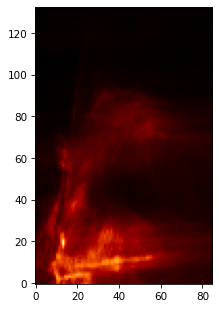

In [86]:
fig = plt.figure(dpi=75)
ax1 = fig.subplots(1, 1)
ax1.imshow(time_distance_array, origin="lower", cmap='sdoaia304')
plt.show()

In [158]:
distance.value

array([ 0.        ,  0.60016501,  1.20033002,  1.80049503,  2.40066004,
        3.00082505,  3.60099005,  4.20115506,  4.80132007,  5.40148508,
        6.00165009,  6.6018151 ,  7.20198011,  7.80214512,  8.40231013,
        9.00247514,  9.60264014, 10.20280515, 10.80297016, 11.40313517,
       12.00330018, 12.60346519, 13.2036302 , 13.80379521, 14.40396022,
       15.00412523, 15.60429023, 16.20445524, 16.80462025, 17.40478526,
       18.00495027, 18.60511528, 19.20528029, 19.8054453 , 20.40561031,
       21.00577532, 21.60594032, 22.20610533, 22.80627034, 23.40643535,
       24.00660036, 24.60676537, 25.20693038, 25.80709539, 26.4072604 ,
       27.00742541, 27.60759041, 28.20775542, 28.80792043, 29.40808544,
       30.00825045, 30.60841546, 31.20858047, 31.80874548, 32.40891049,
       33.0090755 , 33.6092405 , 34.20940551, 34.80957052, 35.40973553,
       36.00990054, 36.61006555, 37.21023056, 37.81039557, 38.41056058,
       39.01072559, 39.61089059, 40.2110556 , 40.81122061, 41.41

In [162]:
#from matplotlib.colors import LogNorm
import matplotlib.dates as mdates

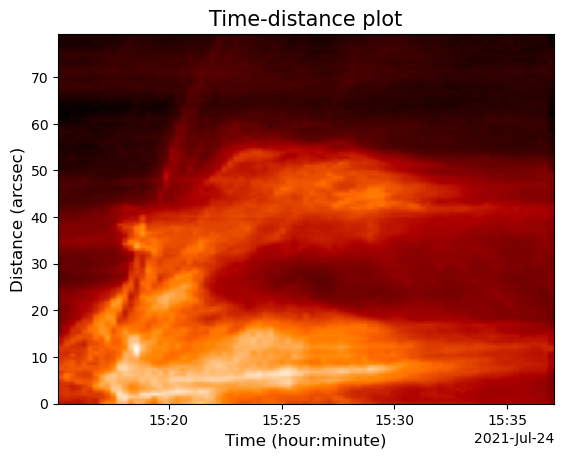

In [166]:
fig = plt.figure(dpi=100)
ax = fig.subplots(1, 1)

x_lims = mdates.date2num(time_array)
y_lims = distance.value

ax.imshow(np.log(time_distance_array), origin="lower", cmap='sdoaia304', 
          extent = [x_lims[0], x_lims[-1],  y_lims[0], y_lims[-1]], 
          aspect='auto')

ax.set_title('Time-distance plot', fontsize = 15)
ax.set_xlabel('Time (hour:minute)', fontsize = 12)
ax.set_ylabel('Distance (arcsec)', fontsize = 12)

ax.xaxis_date()

locator = mdates.AutoDateLocator(minticks=3, maxticks=9)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.show()

We might want to look at features not well seen because faint...

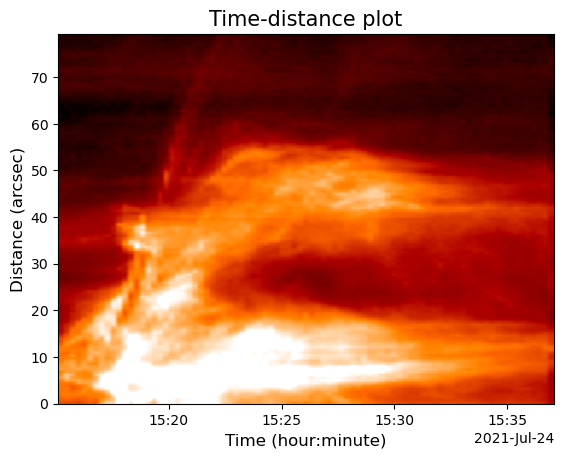

In [177]:
fig = plt.figure(dpi=100)
ax = fig.subplots(1, 1)

x_lims = mdates.date2num(time_array)
y_lims = distance.value

ax.imshow(np.log(time_distance_array), origin="lower", cmap='sdoaia304', 
          extent = [x_lims[0], x_lims[-1],  y_lims[0], y_lims[-1]], 
          aspect='auto', 
          vmax=np.log(time_distance_array.max()/2))

ax.set_title('Time-distance plot', fontsize = 15)
ax.set_xlabel('Time (hour:minute)', fontsize = 12)
ax.set_ylabel('Distance (arcsec)', fontsize = 12)

ax.xaxis_date()

locator = mdates.AutoDateLocator(minticks=3, maxticks=9)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.show()

# Calculate speed

In Solar Jet Hunter, people will be able to draw straight lines (need to explore the curved option). Let's plot some lines

In [183]:
import datetime

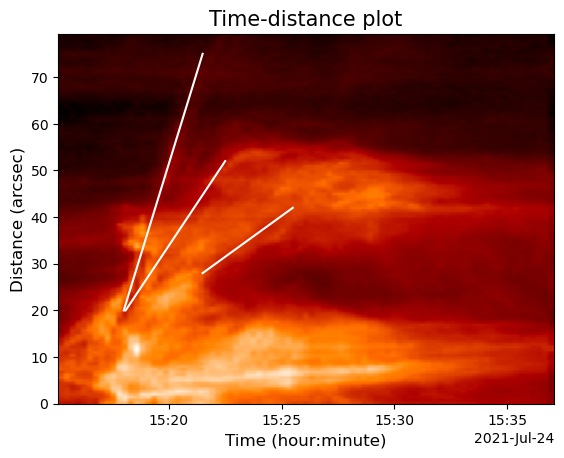

In [204]:
fig = plt.figure(dpi=100)
ax = fig.subplots(1, 1)

x_lims = mdates.date2num(time_array)
y_lims = distance.value

ax.imshow(np.log(time_distance_array), origin="lower", cmap='sdoaia304', 
          extent = [x_lims[0], x_lims[-1],  y_lims[0], y_lims[-1]], 
          aspect='auto')

ax.set_title('Time-distance plot', fontsize = 15)
ax.set_xlabel('Time (hour:minute)', fontsize = 12)
ax.set_ylabel('Distance (arcsec)', fontsize = 12)

ax.xaxis_date()

locator = mdates.AutoDateLocator(minticks=3, maxticks=9)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

time1 = [datetime.datetime(2021,7,24,15,18,0),
         datetime.datetime(2021,7,24,15,21,30)]
dist1 = np.array( [20, 75] )
ax.plot(np.array(mdates.date2num(time1)), dist1, color='white')

time2 = [datetime.datetime(2021,7,24,15,18,5),
         datetime.datetime(2021,7,24,15,22,30)]
dist2 = np.array( [20, 52] )
ax.plot(np.array(mdates.date2num(time2)), dist2, color='white')

time3 = [datetime.datetime(2021,7,24,15,21,30),
         datetime.datetime(2021,7,24,15,25,30)]
dist3 = np.array( [28, 42] )
ax.plot(np.array(mdates.date2num(time3)), dist3, color='white')

plt.show()

Calculate the speeds associated with the lines

In [241]:
dist1_km = 150e6*u.km*np.tan((dist1[1]-dist1[0])*u.arcsec)
dist2_km = 150e6*u.km*np.tan((dist2[1]-dist2[0])*u.arcsec)
dist3_km = 150e6*u.km*np.tan((dist3[1]-dist3[0])*u.arcsec)

In [242]:
speed1 = dist1_km / ((time1[1]-time1[0]).total_seconds()*u.s)
speed2 = dist2_km / ((time2[1]-time2[0]).total_seconds()*u.s)
speed3 = dist3_km / ((time3[1]-time3[0]).total_seconds()*u.s)

In [243]:
print(speed1)
print(speed2)
print(speed3)

190.46252209276537 km / s
87.81530898097293 km / s
42.42119716222735 km / s


   # Afterthoughts

So, now, we want to be able to do this analysis semi-automatically. In fact, we want to use the entries in the sjh catalgue to produce time-distance plots. I will concentrate on this. Outstanding tasks will be also:
- to have an interactive tool in python to plot the lines to calculate the speeds
- to also produce a movie the jet in the box 

## Construction of the code

1. A piece of code to download the cutouts: `download_jet_cutouts`
2. A piece of code to select the cutouts in a folder and to load them into a map sequence `load_jet_cutouts`
3. A piece of code that produce the time-distance plot `compute_time_distance`
All of this will be part of a single script called `time_distance_analysis.py`

### Download the cutouts
This one should take as inputs: the jet start and end time, the SOL FOV, the desired AIA channel.   
The output will be that the cutouts are downloaded in a folder specific to the jet (its name should be the jet id).

### Select the cutouts
This will be easy as all the relevant cutouts will be in a folder specific to the jet. You have to specify the AIA channel.

### Compute the time-distance data
This will be mostly copied from this notebook. The input is the map sequence produced from the selected cutouts.

# Be aware

So far in the code I did not take into account that sometimes the number of pixels in producing a line in the time-distance plot will not be necessarily constent - due to rotation of the Sun - Let's fix that once the code breaks.

In [255]:
%run "time_distance_analysis.py"

ModuleNotFoundError: No module named 'shapely'